In [1]:
get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')


In [2]:
import os
import sys
if 'Single_cell' in os.getcwd():
	os.chdir('../..')
	sys.path.insert(0,os.getcwd())
print(os.getcwd())
print(sys.path[0])

/export/home/enfita/Code/CST_official_github_repo
/export/home/enfita/Code/CST_official_github_repo


In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from lib.CST.utils.utils import factor_number

from matplotlib.lines import Line2D

import matplotlib.pyplot as plt
from lib.CST.T_datacls import T_data
import numpy as np
from lib.CST.T_datacls.utilities.visualisation import plot_graph
from Experiments.Single_cell.load_singlecell_data import load_setty

INFO:numexpr.utils:Note: detected 72 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 72 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


-----
anndata     0.10.7
scanpy      1.10.1
-----
Experiments         NA
PIL                 10.3.0
asttokens           NA
backcall            0.2.0
bottleneck          1.3.8
brotli              1.1.0
certifi             2024.02.02
cffi                1.16.0
charset_normalizer  3.3.2
colorama            0.4.6
comm                0.1.2
cycler              0.12.1
cython_runtime      NA
dateutil            2.9.0
debugpy             1.6.7
decorator           5.1.1
exceptiongroup      1.0.4
executing           0.8.3
fontTools           4.51.0
h5py                3.11.0
idna                3.7
igraph              0.11.4
ipykernel           6.25.0
jedi                0.18.1
joblib              1.4.0
kiwisolver          1.4.5
legacy_api_wrap     NA
leidenalg           0.10.2
lib                 NA
llvmlite            0.42.0
louvain             0.8.2
matplotlib          3.8.4
mpl_toolkits        NA
natsort             8.4.0
networkit           10.1
networkx            3.3
numba               0.

### set parameters

In [4]:
distribution = 'setty'

tree_methods=['BCST_0.40','CST_0.40','mST']#,'BCST_0.70','CST_0.70','BCST_0.00']#,'BCST_1.00','CST_1.00']

#BCST parameters
maxiter_mSTreg=20
maxfreq_mSTreg=3
num_subsamples=1

save=False
folder='Figures/single_cell/'

### Load data and generate pertubed samples

In [5]:
#load data
_,P,P_TSNE,labels,colors=load_setty()

if isinstance(colors[0],str):
    #COLOR to RGB
    def hex_to_rgb(hex_color):
        hex_color = hex_color.lstrip('#')
        return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
    colors=np.array([hex_to_rgb(cls) for cls in colors])/255.

# generate subsampled perturbed data
np.random.seed(12)
subsample_idxs_ls=[]
P_subsample_ls=[]

percentage=0.25
for i in range(num_subsamples):
    subsample_idxs=np.random.choice(np.arange(len(P)), replace=False, size=int(percentage * len(P)))
    subsample_idxs_ls.append(subsample_idxs)
    P_subsample_ls.append(P[subsample_idxs])


n,ndim=P.shape

'''legend'''
# Get unique labels and their corresponding indices
unique_labels, label_indices = np.unique(labels, return_inverse=True)

# Map unique labels to unique numeric codes
string_to_numeric = {label: idx for label, idx in zip(unique_labels, range(len(unique_labels)))}

# Map unique labels to unique colors
label_to_color = {label: color for label, color in zip(labels, colors)}


#legend label names
legend_elements_label_names = [Line2D([0], [0], marker='o', color='w', label=l,
                              markerfacecolor=c, markersize=10)  for l,c in label_to_color.items()]

<KeysViewHDF5 ['X_PCA50', 'X_RAW', 'X_TSNE', 'colors', 'labels']>


In [6]:

param_method={}
for method in tree_methods:
    if 'CST' in method:
        param_method[method] ='itmSTReg=%i_maxfreqmSTreg=%i'%(maxiter_mSTreg,maxfreq_mSTreg)
    if 'mST' in method:
        param_method[method] = ''

### Plot data

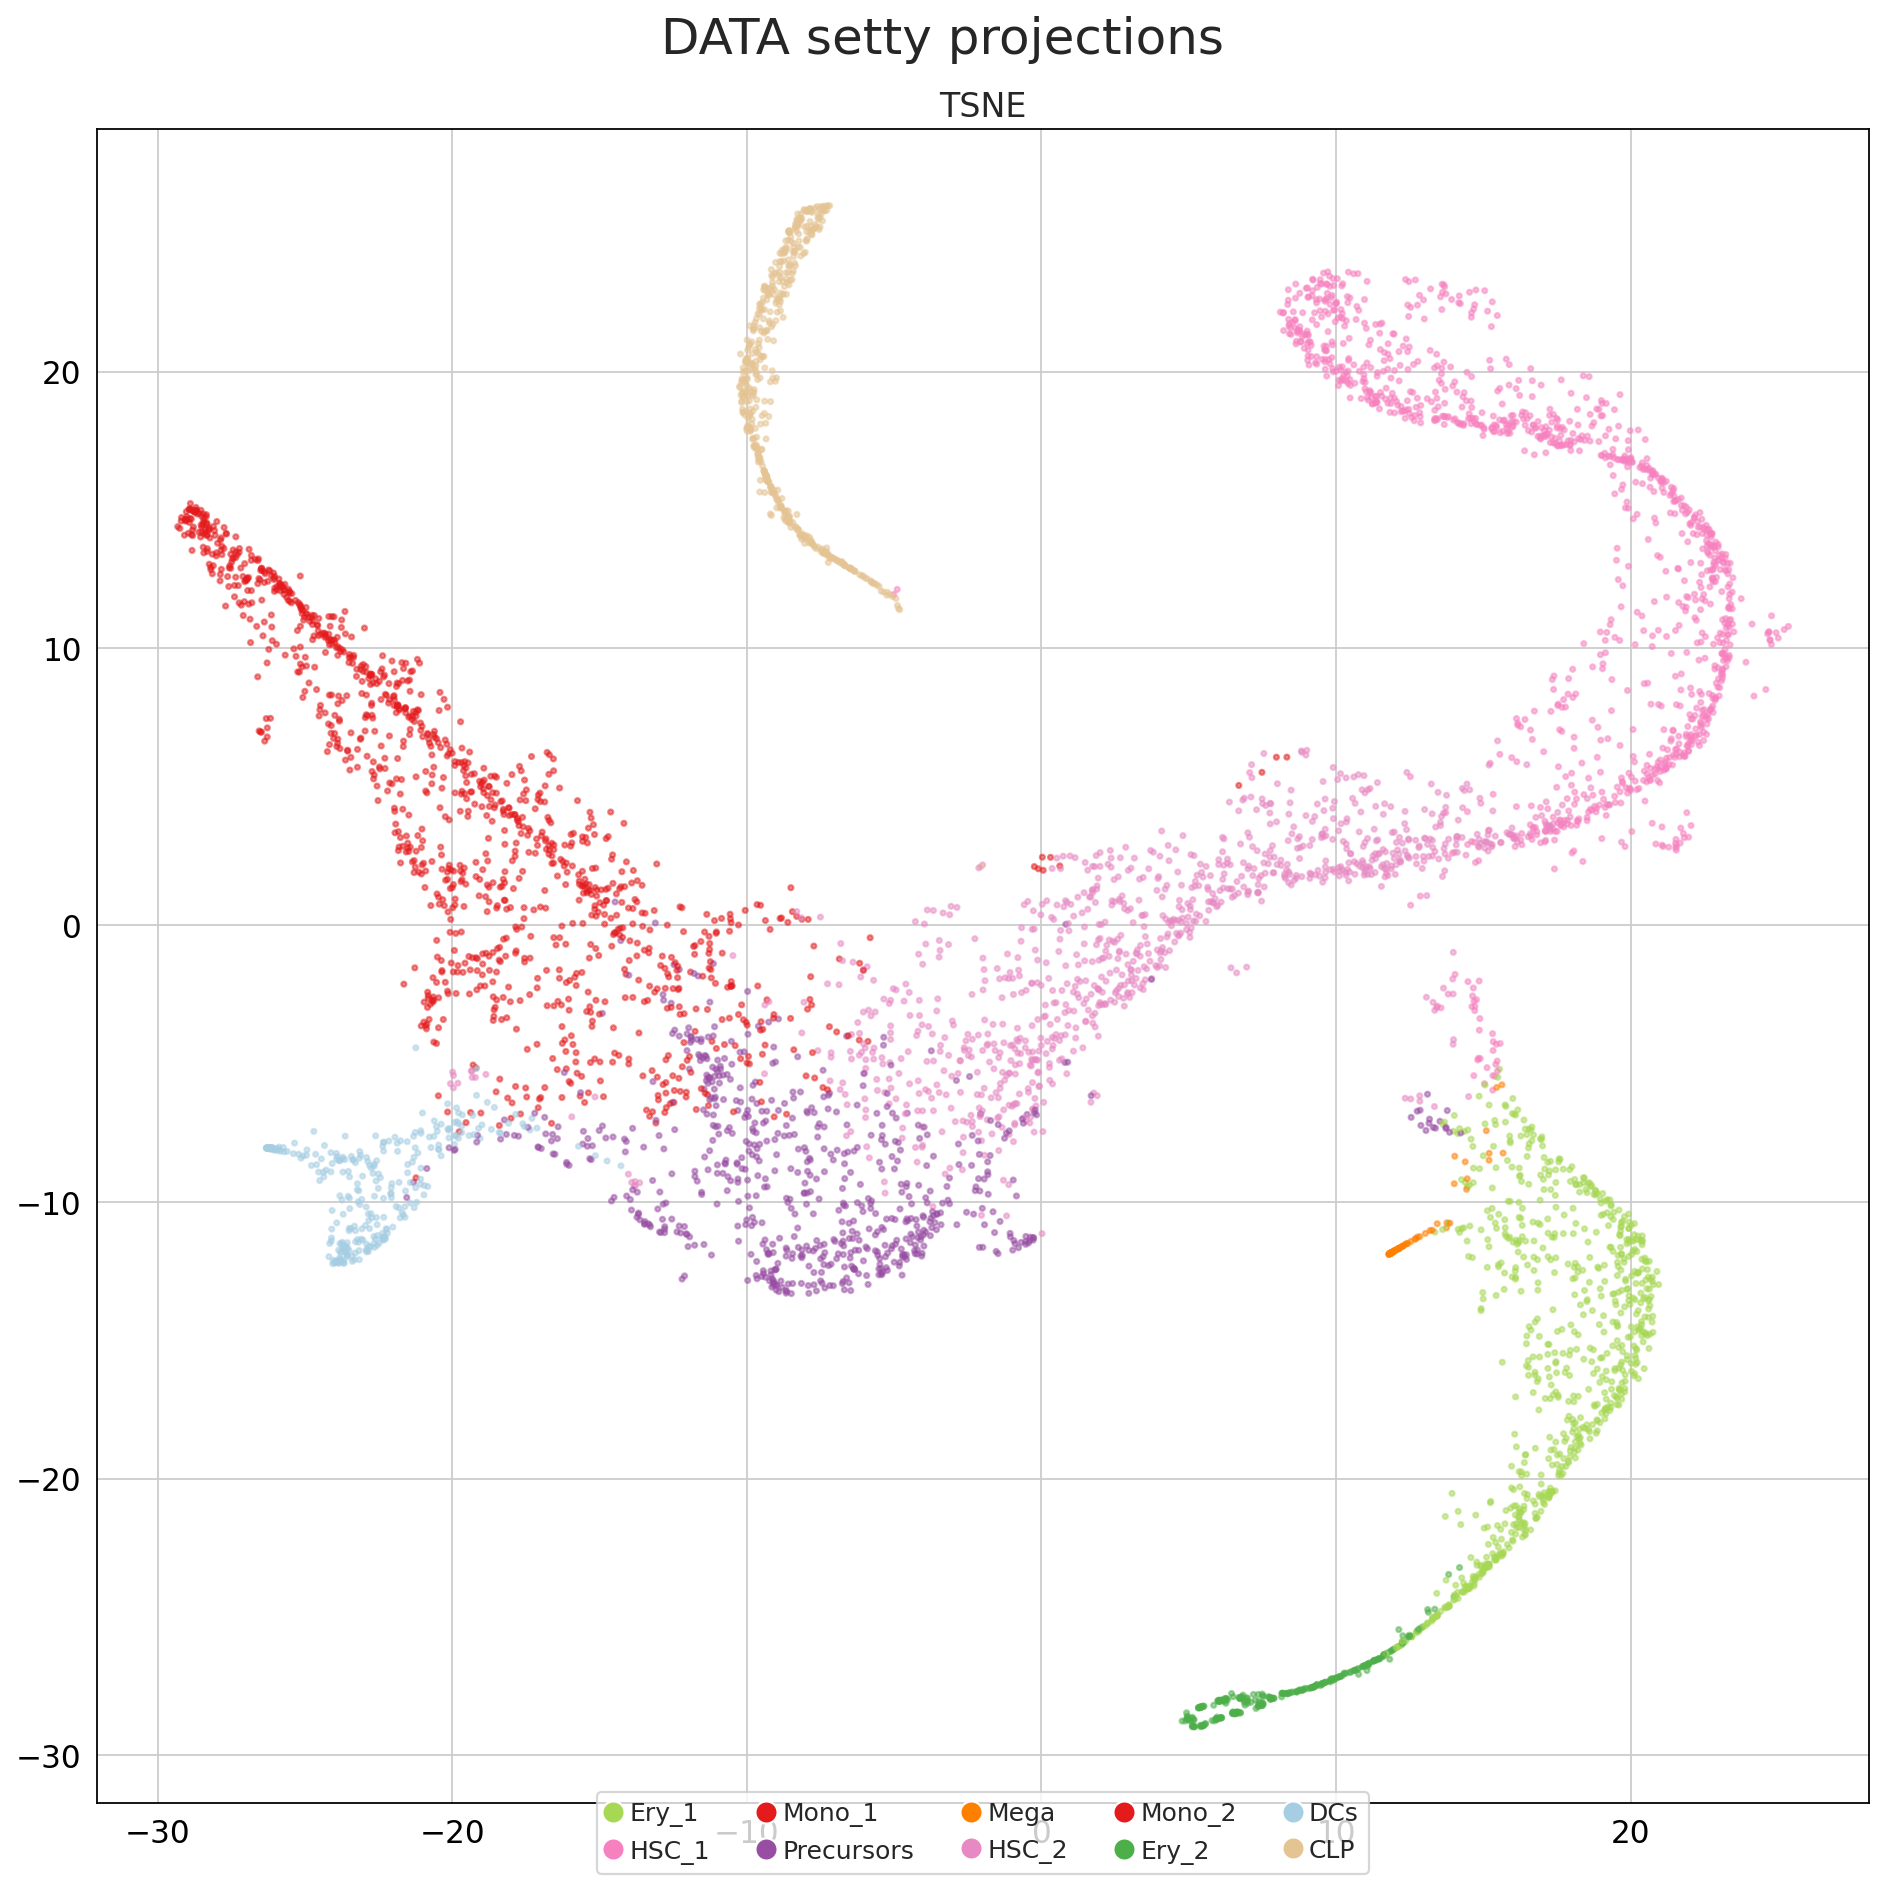

In [7]:
figsize=(12,12)

node_size=5
fontsize=15

plt.figure(figsize=figsize)
plt.scatter(P_TSNE[:,0],P_TSNE[:,1],c=colors,s=node_size,alpha=0.5)
plt.title('TSNE',fontsize=fontsize)
plt.suptitle('DATA %s projections'%distribution,fontsize=1.5*fontsize)
plt.legend(handles=legend_elements_label_names,fontsize=fontsize*.75,
           loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=5)
plt.tight_layout()

plt.show()

### Compute (B)CST

In [8]:
tdata_dict={}
tdata_dict['original']=T_data(P,P_TSNE)
# tdata_dict['noisy']=T_data(P_noise,P_vis_dict[projections_ls[0]])
for i in range(num_subsamples):
    tdata_dict['subsample%i'%i]=T_data(P_subsample_ls[i],P_TSNE[subsample_idxs_ls[i]])


for tdata in tdata_dict.values():
    for method in tree_methods:
        if 'BCST' in method:
            alpha=float(method.split('_')[1])
            if alpha==0:
                return_topo_CST=False
            else:
                return_topo_CST=True
            tdata.compute_BCST(alpha=alpha,
                               maxiter_mSTreg=maxiter_mSTreg,
                               maxfreq_mSTreg=maxfreq_mSTreg,
                               merging_criterium='closest',
                               mST_fromknn=True,
                               return_topo_CST=return_topo_CST,
                               filter_BP_from_solution=True)
        elif method=='mST':
            tdata.minimum_spanning_tree()

INFO:Tdata_logger:Added  'X' to data

INFO:Tdata_logger:Added  'X_vis' to data

INFO:Tdata_logger:Added  'X' to data

INFO:Tdata_logger:Added  'X_vis' to data

INFO:Tdata_logger:Computing initial topology BCST mST
INFO:Tdata_logger:Computing mST 

INFO:Tdata_logger:Added  mST to trees

INFO:Tdata_logger:Computing BCST_0.40 and CST_0.40


best mSTreg obtained in iteration 21
best mSTreg CST obtained in iteration 17


INFO:Tdata_logger:Added  CST_0.40 to trees

INFO:Tdata_logger:Added  BCST_0.40 to trees

INFO:Tdata_logger:Function compute_BCST took 88.5289 seconds
INFO:Tdata_logger:Computing initial topology BCST mST
INFO:Tdata_logger:Computing mST 

INFO:Tdata_logger:Added  mST to trees

INFO:Tdata_logger:Computing BCST_0.40 and CST_0.40
INFO:Tdata_logger:Added  CST_0.40 to trees



best mSTreg obtained in iteration 11
best mSTreg CST obtained in iteration 16


INFO:Tdata_logger:Added  BCST_0.40 to trees

INFO:Tdata_logger:Function compute_BCST took 18.0907 seconds


/export/home/enfita/Code/CST_official_github_repo/lib/CST/T_datacls/utilities/visualisation.py:242: UserWarning: 

The connectionstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default values.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(G, pos=p, width=widths, edge_color=edge_colors, edge_cmap=cmap_edges,


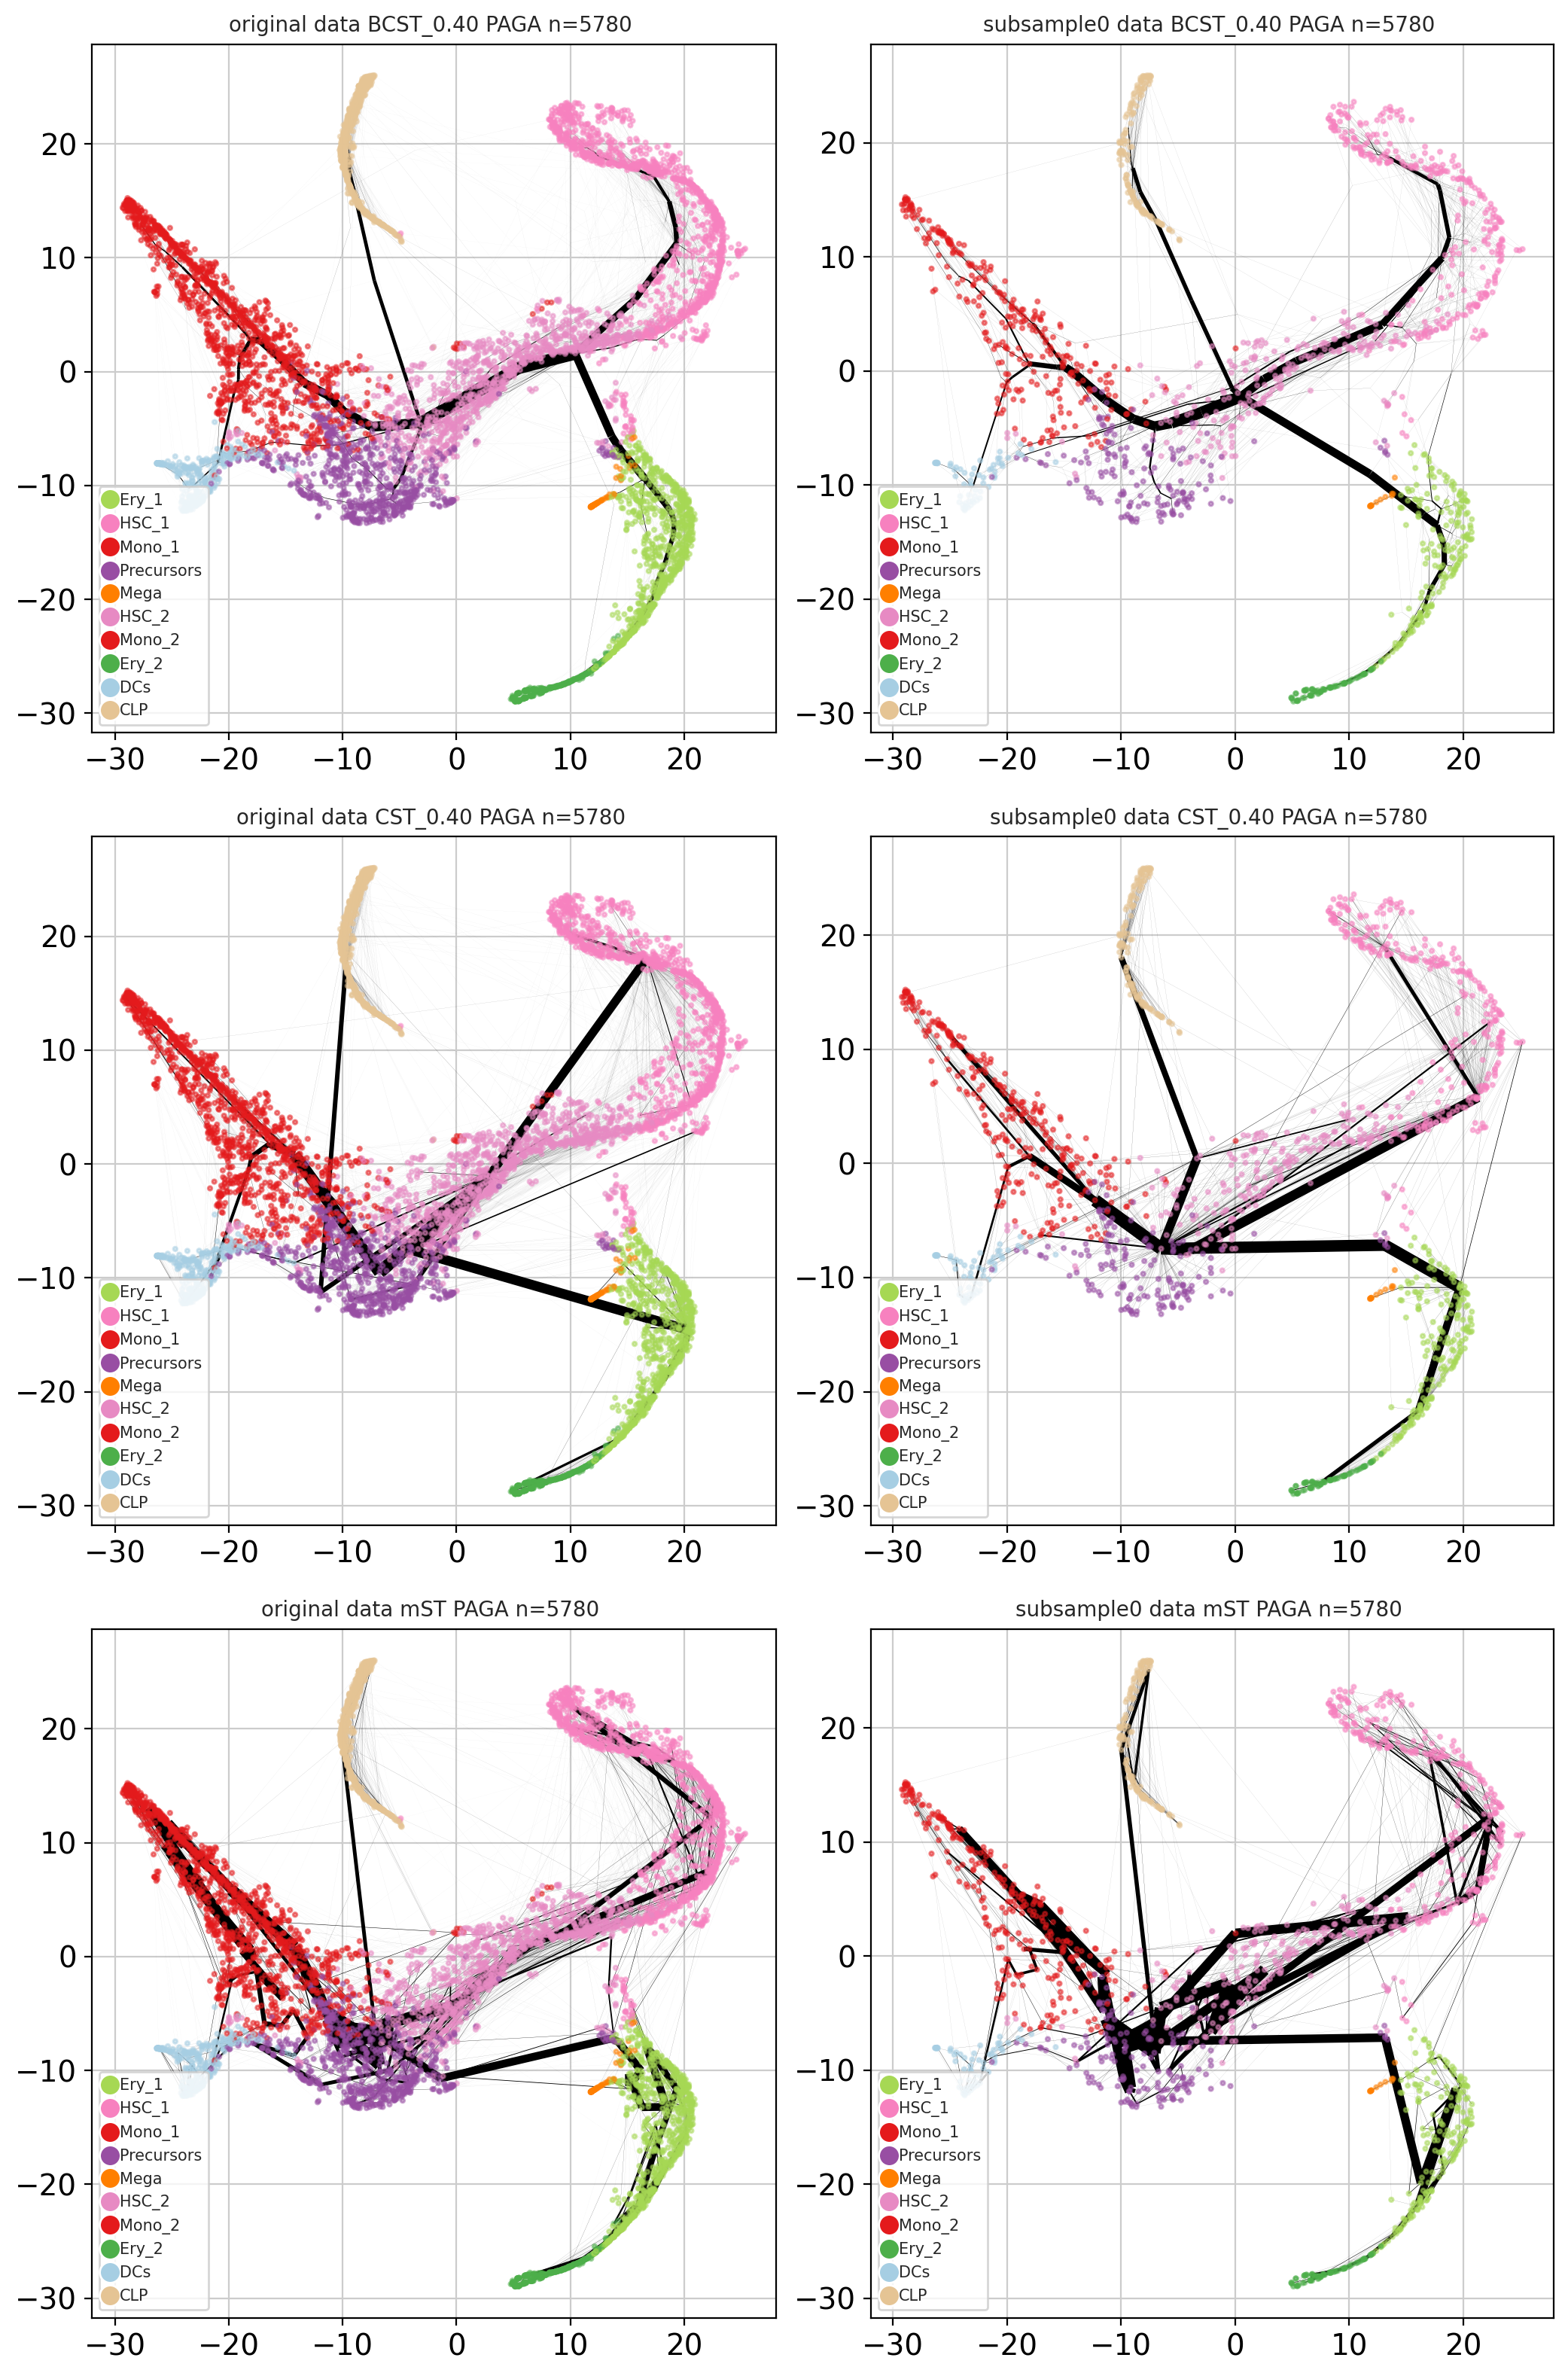

In [9]:
max_width=6
mST = tdata.trees['mST'].T

mST_widths = tdata.trees['mST'].widths*max_width
k1,k2=factor_number(1,reversed=False)
# figsize=(min(4,max(k1,k2))*np.array([6,k1/k2*6])).tolist()
figsize=None#(12,8)
fontsize=10
node_size=4
node_size_BP=0#node_size/30
if save:
    k1=k2=1
else:
    k1=len(tree_methods)
    k2=2

for data_type,tdata in tdata_dict.items():
    if 'subsample' in data_type and 'r' not in data_type:
        idxs=subsample_idxs_ls[int(data_type[-1])]
        is_subsample=1
    else:
        is_subsample=0
        idxs=np.arange(len(P))
    for counter_plot,method in enumerate(tree_methods):
        if save:
            counter_plot=0
        if 'BCST' in method:
            T=tdata.trees[method].T_bp_filtered
            T_widths = tdata.trees[method].widths_filtered * max_width
            visdata=tdata.trees[method].coords_vis_filtered
            node_cls=np.vstack([colors[idxs],colors])[:len(visdata)]
        else:
            T=tdata.trees[method].T
            T_widths = tdata.trees[method].widths * max_width
            visdata=tdata.X_vis
            node_cls=colors[idxs]
        node_size_=node_size

        if np.isclose(min(T_widths),max(T_widths)):
            T_widths=np.ones_like(T_widths)*0.05


        subfolder = '%s/%s_%s/' % (distribution, method,param_method[method])
        file = 'Tree_%s_%s_%s_%s_n=%i_ndim=%i_%s' % (data_type,'PAGA', param_method[method], distribution, n, ndim,method)
        if save:
            title=''
        else:
            title = '%s data %s %s n=%i ' % (data_type,method,'PAGA', n)


        if 'BCST' in method:
            ax=plot_graph(T, visdata, widths=T_widths,
                       title=title, node_size=0,k1=k1,k2=k2,counter_plot=int((not save)*(counter_plot*2+is_subsample)),
                       node_colors=node_cls, figsize=figsize, fontsize=fontsize,
                       alpha_node=0.0,return_ax=True)
            plot_graph(T[:len(idxs)][:,:len(idxs)], visdata[:len(idxs)],
                       widths=0,
                       title=title, node_size=node_size_,k1=k1,k2=k2,counter_plot=int((not save)*(counter_plot*2+is_subsample)),
                       node_colors=node_cls[:len(idxs)], figsize=figsize,
                       fontsize=fontsize,
                       alpha_node=0.5, nodelist=np.arange(len(idxs)),new=False,ax=ax)
        else:
            plot_graph(T, visdata, widths=T_widths,
                       title=title, node_size=node_size_,k1=k1,k2=k2,counter_plot=int((not save)*(counter_plot*2+is_subsample)),
                       node_colors=node_cls, figsize=figsize, fontsize=fontsize,
                       alpha_node=0.5)
        if 'BCST' in method:
            # plt.legend(handles=legend_elements_BP, fontsize=fontsize * .75)
            plt.legend(handles=legend_elements_label_names, fontsize=fontsize * .75,
                       loc='lower left')
        else:
            plt.legend(handles=legend_elements_label_names, fontsize=fontsize * .75,
                       loc='lower left')


        plt.grid('off')
        if save:
            plt.axis('off')
            os.makedirs(folder + subfolder,True)
            plt.savefig(folder+subfolder+file+'.png',dpi=200,transparent=True)
            plt.close()
plt.tight_layout()
plt.show()